In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import sys

# Third party import
import matplotlib.pyplot as plt
import numpy as np
import pywt
from scipy.ndimage import imread

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define the operators

If you want to see the FISTA fail, select `norm = None` and `mode = "symmetric"`.
If you want to see it succeed, select the other 2 commented modes.

In [2]:
# norm = "ortho"
norm = None

def fft(x):
    return np.fft.fft2(x, norm=norm)

def ifft(x):
    return np.fft.ifft2(x, norm=norm)

In [3]:
wavelet_type = "db4"
level = 4
# mode = "zero"
mode = "symmetric"

coeffs_tpl = pywt.wavedecn(data=np.zeros((512, 512)), wavelet=wavelet_type, mode=mode, level=level)
coeffs_1d, coeff_slices, coeff_shapes = pywt.ravel_coeffs(coeffs_tpl)
coeffs_tpl_rec = pywt.unravel_coeffs(coeffs_1d, coeff_slices, coeff_shapes)
_ = pywt.waverecn(coeffs_tpl_rec, wavelet=wavelet_type, mode=mode)

def py_W(im):
    alpha = pywt.wavedecn(data=im, wavelet=wavelet_type, mode=mode, level=level)
    alpha, _, _ = pywt.ravel_coeffs(alpha)
    return alpha
    
def py_Ws(alpha):
    coeffs = pywt.unravel_coeffs(alpha, coeff_slices, coeff_shapes)
    im = pywt.waverecn(coeffs, wavelet=wavelet_type, mode=mode)
    return im

In [4]:
def own_soft_thresh(x, beta):
    sgn_x = x / np.abs(x)
    return np.maximum(np.abs(x) - beta, 0.0) * sgn_x

#  Loading input data

In [5]:
data = imread("lena.png", flatten=True)
original_image_data = np.copy(data)
data += np.random.randn(*data.shape) * 20.

/home/ramzi/workspace/pysap/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """Entry point for launching an IPython kernel.


# Generate the kspace 
From the 2D brain slice and the acquistion mask, we generate the acquisition measurments, the observed kspace. We then reconstruct the zero order solution.

In [6]:
# Generate the subsampled kspace
kspace_data = fft(data)

# Zero order solution
image_rec0 = ifft(kspace_data)

# FISTA optimization
We now want to refine the zero order solution using a FISTA optimization.

## Hyperparams

In [7]:
mu = 100
max_iter = 500
step_size = 0.9  # 1 / Lips constant of the gradient of the data fidelity function, here 1.

## Metrics

In [8]:
def objective_cost(x):
    return data_fidelity(x) + sparsity(x)

def sparsity(x):
    return mu * np.sum(np.abs(x))

def data_fidelity(x):
    fourier = fft(py_Ws(x))
    return 0.5 * np.linalg.norm(np.abs(fourier - kspace_data))**2

In [9]:
def quadratic_approx_data_fid(x, y, L):
    """The quadratic approximation of the data fidelity function in y"""
    grad = py_W(ifft((fft(py_Ws(y)) - kspace_data)))
    return data_fidelity(y) + np.real(np.dot(x-y, np.conjugate(grad))) + (L/2) * np.linalg.norm(x-y)**2

## Optim

In [17]:
t_old = 1
x_old = py_W(np.zeros( (512 , 512)))
x_new = py_W(np.zeros( (512 , 512)))

cost_list = []
data_fid_list = []
quadr_approx_list = []


for i in range(max_iter):
    sys.stdout.write('\r' + str(i))
    # Acceleration
    t_new = (1 + np.sqrt(1 + 4 * t_old**2)) / 2
    a_new = (t_old - 1) / t_new
    y_new = x_new + a_new*(x_new - x_old)
    # Grad and prox
    grad = py_W(ifft((fft(py_Ws(y_new)) - kspace_data)))
    x_new_new = own_soft_thresh(y_new - step_size * grad, beta=step_size * mu)
    # Metric computation
    if i % 20 == 0:
        cost_list.append(objective_cost(x_new_new))
        data_fid_list.append(data_fidelity(x_new_new))
        quadr_approx_list.append(quadratic_approx_data_fid(x_new_new, x_new, L=1 / step_size))
    # variables update
    t_old = t_new
    x_old = x_new
    x_new = x_new_new

x_final = py_Ws(x_new)
image_rec = np.abs(x_final)

499

## Plotting

<IPython.core.display.Javascript object>


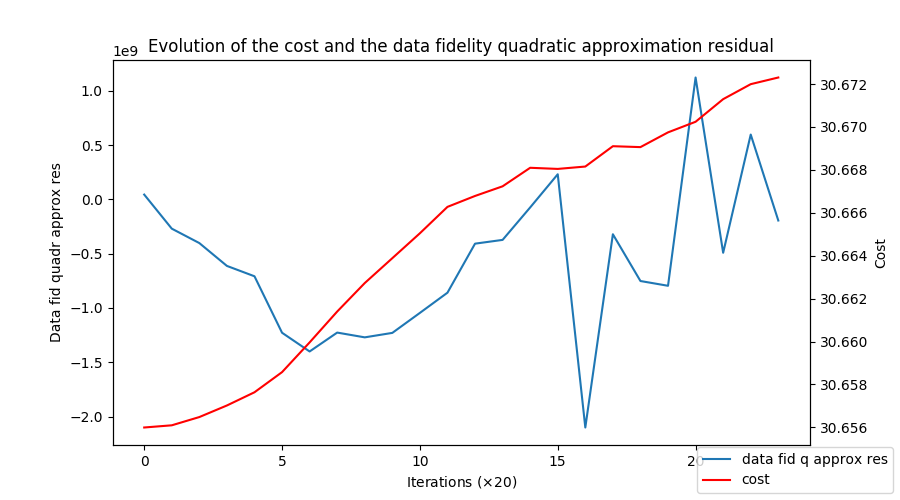

In [18]:
fig, ax1 = plt.subplots(figsize=(9, 5))
focus = 1
ax1.plot(np.array(quadr_approx_list)[focus:] - np.array(data_fid_list)[focus:], label="data fid q approx res")
ax1.set_ylabel("Data fid quadr approx res")
ax1.set_xlabel(r"Iterations ($\times 20$)")
ax1.set_title("Evolution of the cost and the data fidelity quadratic approximation residual")
ax2 = ax1.twinx()
ax2.plot(np.log(cost_list[focus:]), color="red", label="cost")
ax2.set_ylabel("Cost")
fig.legend(loc=4)

## Results

<IPython.core.display.Javascript object>


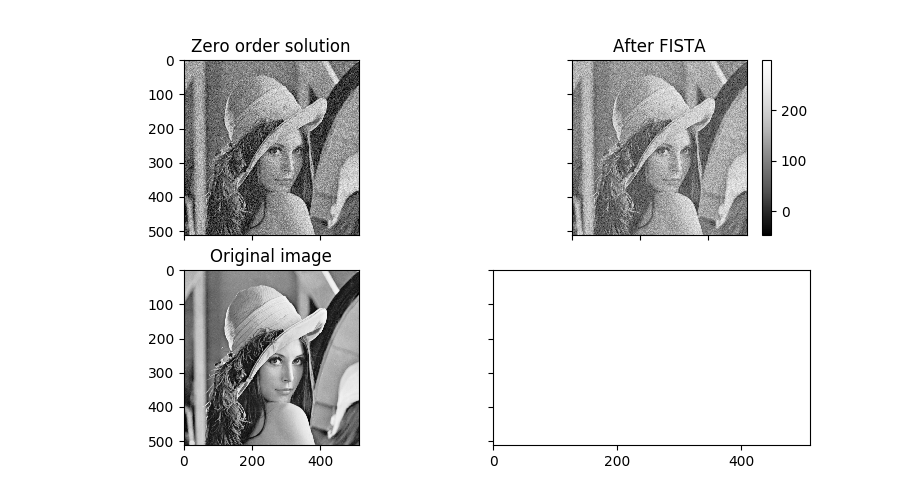

Text(0.5, 1.0, 'After FISTA')

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(9, 5), sharex=True, sharey=True)
axs[1, 0].imshow(original_image_data, cmap='Greys_r')
axs[1, 0].set_title("Original image")
axs[0, 0].imshow(np.abs(data), cmap='Greys_r')
axs[0, 0].set_title("Zero order solution")
im = axs[0, 1].imshow(data, cmap='Greys_r')
fig.colorbar(im, ax=axs[0, 1])
axs[0, 1].set_title("After FISTA")